In [13]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
import glob
from matplotlib.colors import LogNorm

In [3]:
# Run Isidora on the file
input_file = "../data/run_13837_0000_ldc1_trg0.waveforms.h5"
config_file = "../config/irene.conf"

output_file = input_file.split(".waveforms")[0] + "_irene.h5"
!city irene $config_file -i $input_file -o $output_file

input_file  = "../data/run_13837_0000_ldc1_trg0_irene.h5"
output_file = "../data/run_13837_0000_ldc1_trg0_sophronia.h5"
config_file = "../config/sophronia.conf"
!city sophronia $config_file -i $input_file -o $output_file

NumExpr defaulting to 8 threads.
Using selector: KqueueSelector
events processed: 0, event number: 2
NumExpr defaulting to 8 threads.
Using selector: KqueueSelector
events processed: 0, event number: 2


In [11]:
events = pd.read_hdf(output_file,"RECO/Events")
display(events)
print(events.event.unique())

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,37,1.717181e+09,0,-204.725000,-402.175000,1,-373.775,153.125,0.0,0.0,-6.619948,6.333973,0.308259,-1.0,8.681704e-07,-1,-1.0
1,37,1.717181e+09,0,-204.725000,-402.175000,1,-189.175,369.325,0.0,0.0,-6.619948,8.481262,0.412762,-1.0,1.178153e-06,-1,-1.0
2,37,1.717181e+09,0,-204.725000,-402.175000,1,-65.775,260.475,0.0,0.0,-6.619948,5.566734,0.270919,-1.0,7.121734e-07,-1,-1.0
3,37,1.717181e+09,0,-204.725000,-402.175000,1,-373.775,153.125,0.0,0.0,1.063195,6.333973,142.580493,-1.0,4.019198e-04,-1,-1.0
4,37,1.717181e+09,0,-204.725000,-402.175000,1,-204.725,-402.175,0.0,0.0,1.063195,7.878788,177.354954,-1.0,5.342367e-04,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,436,1.717181e+09,2,-190.235192,-218.730466,1,-373.775,153.125,0.0,0.0,160.871930,6.333973,1.819358,-1.0,5.225259e-06,-1,-1.0
5111,436,1.717181e+09,2,-190.235192,-218.730466,1,-312.575,184.225,0.0,0.0,160.871930,5.313093,1.526123,-1.0,4.216058e-06,-1,-1.0
5112,436,1.717181e+09,2,-190.235192,-218.730466,1,10.975,353.775,0.0,0.0,165.834555,6.653871,4.697902,-1.0,1.297136e-05,-1,-1.0
5113,436,1.717181e+09,2,-190.235192,-218.730466,1,165.475,-340.975,0.0,0.0,171.358285,5.541562,-1.735464,-1.0,-4.861059e-06,-1,-1.0


[ 37  58 100 107 114 142 198 289 429 436]


In [84]:
event = events[events.event == 37]
event = event[["X", "Y", "Z", "E"]]
display(event)

# rebin the event
# Min x val, max x val, x bin w (y are set equal to this)
xmin=-500; xmax=500; xbw=10

# Min z val, max z val, z bin w (in case of S2, we just want one bin in EL)
zmin=0; zmax=1200; zbw=10

# Create the bins
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = xbins
zbins = np.arange(zmin, zmax+zbw, zbw)

xbins_centre = np.arange(xmin+xbw/2, xmax+xbw/2, xbw)
ybins_centre = xbins_centre
zbins_centre = np.arange(zmin+zbw/2, zmax+zbw/2, zbw)

# Now bin the x, y, z positions
event['X'] = pd.cut(x=event['X'], bins=xbins,labels=xbins_centre, include_lowest=True)
event['Y'] = pd.cut(x=event['Y'], bins=ybins,labels=ybins_centre, include_lowest=True)
event['Z'] = pd.cut(x=event['Z'], bins=zbins,labels=zbins_centre, include_lowest=True)

event = event.groupby(['X', 'Y', 'Z'], as_index=False).sum()
event = event[event.E>1000]

display(event)


,X,Y,Z,E
0,-373.775,153.125,-6.619948,0.308259
1,-189.175,369.325,-6.619948,0.412762
2,-65.775,260.475,-6.619948,0.270919
3,-373.775,153.125,1.063195,142.580493
4,-204.725,-402.175,1.063195,177.354954
...,...,...,...,...
1168,73.175,-309.875,1119.128455,53.584492
1169,181.025,-186.475,1119.128455,42.988010
1170,-281.475,153.125,1124.553765,29.032960
1171,396.725,122.025,1136.086110,22.638431


,X,Y,Z,E
286783,-265.0,395.0,1035.0,1543.010241
771221,145.0,-235.0,1015.0,1558.401275
856420,215.0,-135.0,1005.0,1941.472139
867935,225.0,-175.0,955.0,1522.552538
868175,225.0,-155.0,955.0,1268.811354
...,...,...,...,...
940297,285.0,-145.0,975.0,1230.397453
940535,285.0,-125.0,955.0,1295.454104
963935,305.0,-175.0,955.0,1992.954192
964175,305.0,-155.0,955.0,1708.464692


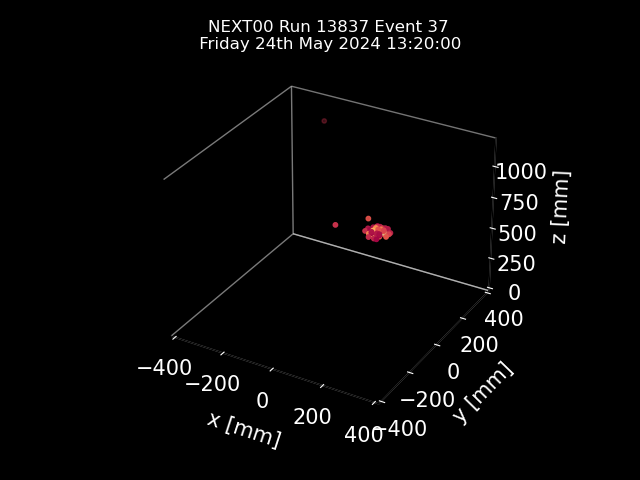

In [117]:
%matplotlib widget


# Make a 3D view of the track
# fig  = plt.figure(figsize=(10, 10))
with plt.ioff():
    fig, axis = plt.subplots()

# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

fig.set_facecolor('black')
ax.set_facecolor('black')
sc = ax.scatter(event.X, event.Y,  event.Z,c= event.E, cmap='Spectral', s=10, label = "SiPM hits")


ax.set_xlabel("x [mm]", fontsize = 15, labelpad=10)
ax.set_ylabel("y [mm]", fontsize = 15, labelpad=10)
ax.set_zlabel("z [mm]", fontsize = 15, labelpad=10)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

# Remove background (axis)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


# Add colorbar
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label('Energy [PE] (uncalibrated)')
# cbar.ax.patch.set_alpha(0)
# cbar.outline.set_edgecolor('none')


ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
ax.set_zlim(0, 1200)
axis.axis('off')
ax.grid(False)

title = ax.set_title("NEXT100 Run 13837 Event 37\n Friday 24th May 2024 13:20:00")
title.set_color('white')


# logo_img = plt.imread('/Users/mistryk2/OneDrive - University of Texas at Arlington/Slides/Templates/NEXT LOGO White small.png')
# x_pos = 0.7 * fig.get_figwidth()
# y_pos = 0.7 * fig.get_figheight()
# fig.figimage(logo_img, x_pos, y_pos,zorder=10)
# legend = plt.legend(facecolor = "black")

# Set the text color of the legend
# for text in legend.get_texts():
    # text.set_color('white')  # Set the text color to red

disconnect_zoom = zoom_factory(axis)
# Enable scrolling and panning with the help of MPL
# Interactions library function like panhandler.
pan_handler = panhandler(fig)
display(fig.canvas)

plt.savefig("NEXT100_Alpha.png",dpi=1000)